# LOT STREAMING JOB SHOP SCHEDULING GENETIC ALGORITHM

In this notebook is shown how to use this set of scripts to produce a job shop scheduling with lot streaming with objective makespan. 

## Main features
- lot streaming (setting max number of lots for each job)
- Possibility of handling shift constraints
- Possibility of handling sequence dependent setup times

**Results were verified to be near to optimal through MILPs models solving small instances.**

Let's first import the main classes.

In [18]:
from jobshop import JobShopRandomParams # Random parameters for job shop scheduling
from genetic.algorithm import GeneticAlgorithm # Genetic Algorithm implementation
from plotting import Plotter # Plotting utilities for results visualization
from genetic import ChromosomeGenerator # Chromosome generation utilities
from scheduling import Scheduler # Scheduling utilities for job shop scheduling

## Job Shop Parameters

The **Job Shop Parameters** define the problem instance that the Genetic Algorithm will solve.
They are stored in a YAML configuration file inside `config/jobshop/`.

The configuration controls:

* **Problem size** (number of jobs, machines, and lots),
* **Operation durations** and **setup times**,
* **Random generation settings** for reproducibility,
* **Optional constraints** such as production shifts.

### Example configuration

```yaml
# Job Shop Scheduling Parameters Configuration

job_shop:
  n_machines: 3        # Number of machines in the shop
  n_jobs: 3            # Number of jobs to be scheduled
  n_lots: 3            # Number of lots per job

processing_times:
  t_span: [1, 20]      # Range (in minutes) for operation processing times

setup_times:
  setup_mode: independent  # 'independent' → constant setup per job/machine
                           # 'dependent'   → sequence-dependent setup times
  t_span_setup: [50, 100]  # Range (in minutes) for setup times

random:
  seed: 4              # Fix for reproducible random instance generation

fixed_params:
  demand_per_job: 150  # Total units to produce per job

shift:
  shift_constraint: False  # True → enforce shift-based schedule limits
  shift_time: 480          # Shift duration in minutes (e.g., 480 = 8h)
```

### Output of parameter generation

When the script reads this configuration, it **randomly generates** the following instance data:

* **Processing times**: Matrix of operation durations for each job on each machine.
* **Setup times**: Either constant or sequence-dependent, depending on `setup_mode`.
* **Operation sequences**: Routing of each job through the machines.

These generated parameters are then passed to the **decoder** and **Genetic Algorithm** for scheduling.

In [19]:
# Generate random parameters for the job shop scheduling problem
problem_params = JobShopRandomParams(config_path="config/jobshop/js_params_01.yaml")
                             
# Print the generated parameters
problem_params.print_jobshop_params()

Job-Shop Parameters:
[MACHINES]: 
 [0 1 2] 

[JOBS]: 
 [0 1 2] 

[BATCHES]: 
 [0 1 2] 

[DEMAND]: 
 {0: 150, 1: 150, 2: 150, 3: 150} 

[SEQ INDEPENDENT SETUP TIMES] the setup time associated with each job on each machine is:
           Job 0  Job 1  Job 2
Machine 0     96     55     51
Machine 1     90     73     58
Machine 2     59     89     95 

[PROCESS TIMES]the working time associated with each job on each machine is:
           Job 0  Job 1  Job 2
Machine 0     15      6      2
Machine 1      9      9     19
Machine 2     10      8     14 

[SEQ] the sequence for each job is: 
0 | [0, 1, 2]
1 | [2, 0]
2 | [0]


## CHROMOSOME GENERATION AND CODIFICATION

Chromosomes consist of 2 parts, the LEFT HAND SIDE (lhs) and the RIGHT HAND SIDE (rhs).

- LHS: for each job there are $u$ real numbers between 0 and 1 that indicate the size of each lot.
- RHS: as this is a JSP, not a FSP, we will have $u$ x $n$ elements in this side, one for each lot of each job.

This codification has been built following the idea showed in this paper.



| 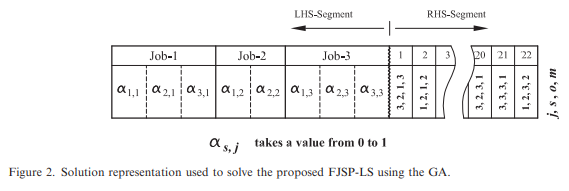| 
|:--:| 
| *Image taken from Fantahun M. Defersha & Mingyuan Chen (2012)* |

Through the script *src/genetic/chromosome.py*, a random chromosome is created. Each one is a list containing both sides. 

### Generation 
- LHS contains a np.array with all $\alpha_ju$ values between 0 and 1 generated with random.random()
- RHS contains a list of tuples. Each tuple refers to each lot of each job.
- CHROMOSOME contains a list with both sides.

 ~~~
chromsome_lhs = np.array([0.24874627, 0.98784599, 0.18476245,..])
chromosome_rhs = [(1, 2), (2, 2), (0, 0),...]
chromosome = [chromosome_lhs, chromosome_rhs]
 ~~~

### Decodification

1. Chromosome_lhs values are transformed into integer numbers regarding the demand of each job through the function *src/scheduling/lot_sizing.py/distribute_demand()*<br>
   `chromosome_lhs = np.array([19., 17., 14.,...])`
2. A semiactive schedule (*A feasible schedule is called semiactive if no operation can be completed earlier without changing the order of processing on any one of the machines.*) is built through the method *Scheduler.decode(chromosome)* that returns:
- makespan
- setup start time of each lot
- completion time of each lot
- chromosome with LHS containing integer numbers (units of product in each lot)
- penalty in case of having lot sizes (traduced in lot processing times) bigger than allowed timeshift windows

The function *Scheduler.decode(chromosome)* can handle **4 different cases**:
- **no shift** constraints & sequence **independent** setup times
- **shift** constraints & sequence **independent** setup times
- **no shift** constraints & sequence **dependent** setup times
- **shift** constraints & sequence **dependent** setup times

Therefore, later when working with the genetic algorithm we will be able to choose to enable shift constraints and sequence dependent setup times.

*Shift constraints mean all tasks have to be scheduled within a time window, have to start and finish within a time window.*

### Example of generation and decodification


In [20]:
my_chromosome = ChromosomeGenerator(problem_params).generate()
my_scheduler = Scheduler(problem_params)
makespan, penalty, start_time, completion_time, semidecoded_chr  = my_scheduler.decode(my_chromosome)
print("Makespan: \n", makespan)
print("Shift penalty: \n", penalty)
print("Setup start times: \n", start_time)
print("Completion times: \n", completion_time)
print("Chromosome with LHS containing units: \n", semidecoded_chr)

Makespan: 
 4268
Shift penalty: 
 0
Setup start times: 
 [[[2015 1655  149]
  [3737 2991 3352]
  [2846    0 1856]]

 [[2846 2591 1655]
  [   0    0    0]
  [   0    0    0]]

 [[3719 3590 2591]
  [ 529  970    0]
  [   0    0    0]]]
Completion times: 
 [[[2846 1856 1655]
  [4056 3352 3737]
  [2991  149 2015]]

 [[3377 2744 2591]
  [   0    0    0]
  [   0    0    0]]

 [[4268 3719 3590]
  [ 970 1467  529]
  [   0    0    0]]]
Chromosome with LHS containing units: 
 [array([49,  7, 94, 44, 51, 55, 47, 49, 54]), [(2, 1), (0, 2), (0, 2), (0, 1), (2, 2), (1, 2), (1, 0), (0, 1), (0, 0), (1, 1), (0, 0), (2, 0), (0, 2), (1, 1), (1, 2), (0, 1), (1, 0), (0, 0)]]


## GENETIC ALGORITHM

The GA is developed using the functions from DEAP package. The function is
  
### Fitness

- NO SHIFT CONSTRAINTS: fitness = makespan
- SHIFT CONSTRAINTS: fitness = makespan + shift penalty

### Selection

In each generation, the initial population is created through **tournament selection**. 
1. 3 individuals are selected from each generated population
2. the best of these 3 (the one with the lowest fitness) is selected to be part of the initial population.
3. Repeat 1 and 2 until having the desired amount of population
   
### Genetic Operators

**crossover** genetic operators are:
- for LHS
  - Single Point Crossover-1 (SPC-1)
  - Single Point Crossover-2 (SPC-2)
- for RHS
  - Partially Mapped Crossover (PMX)
  - Ordered Crossover (OX)
  
**mutation** genetic operators are:
- for LHS
  - Sublot Step Mutation (SStM)
- for RHS
  - Shuffle mutation

### Probabilities for Genetic Operators

Probabilities may be changed and a DoE (design of experiments) could be done to investigate their effects. In this initial performance, selected values are these:

- Crossover operators (SPC1, SPC2, PMX, OX) = 0.8
- Mutation operator (SStM) = 0.2



## Results & Visualization

This project produces two main visual outputs:

### 1) Interactive Gantt chart (Plotly)

Built with **`plotly.express.timeline`**, the Gantt chart visualizes the final schedule by **machine**, **job** and **lot** (operation ID).
For each lot of each job on each machine, the chart shows:

* **Setup start time**
* **Lot start (processing) time**
* **Completion time**
* **Lot size**

The chart is fully interactive (hover tooltips, zoom, pan, and legend filtering).
Figures are saved under `results/schedule/` and also display inline in the notebook.

### 2) Fitness evolution (Matplotlib)

A Matplotlib figure tracks the **best fitness (e.g., makespan)** across generations of the genetic algorithm, letting you see convergence behavior at a glance.
Figures are saved under `results/fitness_evolution/`.

## EXAMPLE OF GA RUN AND SOLUTION PLOT

A piece of code to easily run and plot the solution from the GA.

You can also easily change constraints and parameters

18:30:38.225 Generation 0 completed in 0.03590989112854004 seconds
18:30:38.225 Best fitness of this population: 4056.0
18:30:38.261 Generation 1 completed in 0.03605008125305176 seconds
18:30:38.262 Best fitness of this population: 4056.0
18:30:38.291 Generation 2 completed in 0.02987837791442871 seconds
18:30:38.291 Best fitness of this population: 4056.0
18:30:38.327 Generation 3 completed in 0.03535270690917969 seconds
18:30:38.327 Best fitness of this population: 4056.0


Job-Shop Parameters:
[MACHINES]: 
 [0 1 2] 

[JOBS]: 
 [0 1 2] 

[BATCHES]: 
 [0 1 2] 

[DEMAND]: 
 {0: 150, 1: 150, 2: 150, 3: 150} 

[SEQ INDEPENDENT SETUP TIMES] the setup time associated with each job on each machine is:
           Job 0  Job 1  Job 2
Machine 0     96     55     51
Machine 1     90     73     58
Machine 2     59     89     95 

[PROCESS TIMES]the working time associated with each job on each machine is:
           Job 0  Job 1  Job 2
Machine 0     15      6      2
Machine 1      9      9     19
Machine 2     10      8     14 

[SEQ] the sequence for each job is: 
0 | [0, 1, 2]
1 | [2, 0]
2 | [0]


18:30:38.359 Generation 4 completed in 0.03244280815124512 seconds
18:30:38.359 Best fitness of this population: 3960.0
18:30:38.392 Generation 5 completed in 0.03316092491149902 seconds
18:30:38.392 Best fitness of this population: 4001.0
18:30:38.428 Generation 6 completed in 0.035400390625 seconds
18:30:38.428 Best fitness of this population: 3950.0
18:30:38.468 Generation 7 completed in 0.04041242599487305 seconds
18:30:38.469 Best fitness of this population: 4001.0
18:30:38.501 Generation 8 completed in 0.03110361099243164 seconds
18:30:38.502 Best fitness of this population: 4001.0
18:30:38.524 Generation 9 completed in 0.022058486938476562 seconds
18:30:38.538 Best fitness of this population: 4035.0
18:30:38.570 Generation 10 completed in 0.03130316734313965 seconds
18:30:38.570 Best fitness of this population: 3997.0
18:30:38.606 Generation 11 completed in 0.034522056579589844 seconds
18:30:38.606 Best fitness of this population: 3997.0
18:30:38.641 Generation 12 completed in 0

Function GeneticAlgorithm.run took 3.7186620235443115 seconds to run

Best makespan found: 3844.0
Best fitness history: [4056.0, 4056.0, 4056.0, 4056.0, 3960.0, 3960.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3899.0, 3899.0, 3899.0, 3899.0, 3899.0, 3899.0, 3899.0, 3899.0, 3899.0, 3899.0, 3899.0, 3899.0, 3865.0, 3865.0, 3865.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0, 3844.0]


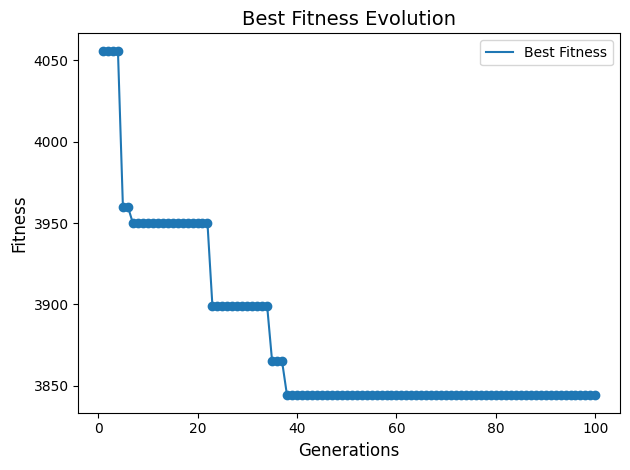

WindowsPath('C:/Users/EM2025007548/Documents/OR/lot-streaming-job-shop-scheduling-genetic-algorithm/results/fitness_evolution/evolution_m3_j3_u3_s4_d150_shifts_480_setup_False_20250810_183043.png')

In [21]:
from shared.utils import init_logger

logger = init_logger()
problem_params = JobShopRandomParams(config_path="config/jobshop/js_params_01.yaml")
problem_params.print_jobshop_params()

GA = GeneticAlgorithm(
    problem_params, logger, config_path="config/genetic_algorithm/ga_config_01.yaml"
)
makespan, best_fitness_history, best_individual = GA.run()

# Print results
print("Best makespan found:", makespan)
if problem_params.shift_constraints:
    penalty = GA.scheduler.decode(best_individual)[1]
    print("Penalty:", penalty)
print("Best fitness history:", best_fitness_history)

# Plotting results
ops = GA.scheduler.build_operations(best_individual)
plotter = Plotter(problem_params)
plotter.plot_gantt(ops, save=True, open=True)
plotter.plot_solution_evolution(best_fitness_history, save=True, open=True)